# Partie 1

## Modules

In [1]:
import openpyxl
from read_input import read_input

from gurobipy import *
import math
import numpy 
import time

## Lecture des données

In [2]:
start_time = time.time()

ville="Australia" #  changer 
ressources,ressources_unavailabilities,tasks,tasks_unavailabilities = read_input(2,ville)
# V1 : "Bordeaux", "Finland", "GuineaGolf", "Italy", "Poland"
# V2 : "Austria", "Australia", "Bordeaux", "Poland", "Spain"

## Structures de données

In [3]:
def dist(lat1, long1, lat2, long2):
    """
    fonction renvoyant la distance en kms entre deux points décrits par leur latitude et longitude
    """
    if lat1==lat2 and long1==long2:
        return 0
    return(numpy.arccos(numpy.sin(2*numpy.pi/360*lat1)*numpy.sin(2*numpy.pi/360*lat2)+numpy.cos(2*numpy.pi/360*lat1)*numpy.cos(2*numpy.pi/360*lat2)*numpy.cos(2*numpy.pi/360*(long2-long1)))*6371)

#ACOS(SIN(lat1)*SIN(lat2)+COS(lat1)*COS(lat2)*COS(lon2-lon1))*6371
vitesse=5/6

L_ressources = [j for j in ressources] # tableau des objets ressources 
L_tasks = [i for i in tasks] # tableau des objets taches
number_of_ressources = len(L_ressources)
number_of_tasks = len(L_tasks)

# dictionnaire des positions des tâches
dict_pos = {task : (tasks[L_tasks[task]].latitude, tasks[L_tasks[task]].longitude) for task in range(number_of_tasks)} 


#Liste des indisponibilités de ressource
runav_id = []
for j in range(len(L_ressources)):
    for u in range(len(ressources[L_ressources[j]].unavailabilities)):
        runav_id.append((j,u))
number_of_runavailabilities = len(runav_id)

#Liste des indisponibilités de tâche
tunav_id = []
for i in range(len(L_tasks)):
    for v in range(len(tasks[L_tasks[i]].unavailabilities)):
        tunav_id.append((i,v))
number_of_tunavailabilities = len(tunav_id)

#distance[a][b] donne la distance de la tâche a vers la tâche b
def distance_tache_unav():
    distances = [[0 for j in range(number_of_tasks+number_of_runavailabilities)] for i in range(number_of_tasks+number_of_runavailabilities)]
    for b in range(number_of_tasks+number_of_runavailabilities) :
        for a in range(number_of_tasks+number_of_runavailabilities) :
            if a >= number_of_tasks and b >= number_of_tasks :
                distances[a][b] = dist(ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].latitude, ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].longitude, ressources[L_ressources[runav_id[b-number_of_tasks][0]]].unavailabilities[runav_id[b-number_of_tasks][1]].latitude, ressources[L_ressources[runav_id[b-number_of_tasks][0]]].unavailabilities[runav_id[b-number_of_tasks][1]].longitude)
            elif a >= number_of_tasks and b < number_of_tasks :
                distances[a][b] = dist(ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].latitude, ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].longitude, tasks[L_tasks[b]].latitude, tasks[L_tasks[b]].longitude)
            elif a < number_of_tasks and b >= number_of_tasks :
                distances[a][b] = dist(ressources[L_ressources[runav_id[b-number_of_tasks][0]]].unavailabilities[runav_id[b-number_of_tasks][1]].latitude, ressources[L_ressources[runav_id[b-number_of_tasks][0]]].unavailabilities[runav_id[b-number_of_tasks][1]].longitude, tasks[L_tasks[a]].latitude, tasks[L_tasks[a]].longitude)
            else :
                distances[a][b] = dist(tasks[L_tasks[a]].latitude,tasks[L_tasks[a]].longitude, tasks[L_tasks[b]].latitude, tasks[L_tasks[b]].longitude)
    return distances
distances=distance_tache_unav()

#distance_m[j][i] donne la distance de la maison de j la tâche i
def distance_maison_unav():
    distances_m = [[0 for j in range(number_of_tasks+number_of_runavailabilities)] for i in range(number_of_ressources)]
    for t in range(number_of_tasks+number_of_runavailabilities) :
        for r in range(number_of_ressources) :
            if t >= number_of_tasks :
                distances_m[r][t] = dist(ressources[L_ressources[runav_id[t-number_of_tasks][0]]].unavailabilities[runav_id[t-number_of_tasks][1]].latitude, ressources[L_ressources[runav_id[t-number_of_tasks][0]]].unavailabilities[runav_id[t-number_of_tasks][1]].longitude, ressources[L_ressources[r]].latitude,ressources[L_ressources[r]].longitude)
            else :
                distances_m[r][t] = dist(ressources[L_ressources[r]].latitude,ressources[L_ressources[r]].longitude, tasks[L_tasks[t]].latitude, tasks[L_tasks[t]].longitude)
    return distances_m
distances_m=distance_maison_unav()

# https://gurobi.github.io/modeling-examples/technician_routing_scheduling/technician_routing_scheduling.html

## Variables de décision

In [4]:
### Create Model
m = Model("trs0")

# Borne supérieure des horaires
M = 1440

### Decision variables
# Task-ressource assignment
x = {(t,r) : m.addVar(vtype = GRB.BINARY, name = f'x_{t}_{r}') for r in range(number_of_ressources) for t in range(number_of_tasks)}
for r in range(number_of_ressources):
    for u in range(number_of_runavailabilities):
        if runav_id[u][0]==r:
            x[(number_of_tasks+u,r)]=1
        else:
            x[(number_of_tasks+u,r)]=0

# Time-task assignment
s = {t : m.addVar(vtype = GRB.INTEGER, lb = 0, ub = 1440, name = f's_{t}') for t in range(number_of_tasks)}
#Les s_t valent entre 0 et 1440 car les contraintes de temps (entre 8h et 18h) sont contenues dans les jeux de données.
for u in range(number_of_runavailabilities):
    s[number_of_tasks+u]=ressources[L_ressources[runav_id[u][0]]].unavailabilities[runav_id[u][1]].unavailabilityStart

# Est-ce que le travailleur se déplace entre les points a et b ?
y = {(r,a,b) : m.addVar(vtype = GRB.BINARY, name = f'y_{r}_{a}_{b}') for r in range(number_of_ressources) for a in range(number_of_tasks+number_of_runavailabilities) for b in range(number_of_tasks+number_of_runavailabilities)}# if a != b}
# Technician cannot leave or return to a depot that is not its base

# Is the worker used ?
u = {r: m.addVar(vtype = GRB.BINARY, name = f'u_{r}') for r in range(number_of_ressources)}

# starting task of worker
d = {(r,t) : m.addVar(vtype = GRB.BINARY, name = f'd_{r}_{t}') for r in range(number_of_ressources) for t in range(number_of_tasks+number_of_runavailabilities)}
# ending task of worker
f = {(r,t) : m.addVar(vtype = GRB.BINARY, name = f'f_{r}_{t}') for r in range(number_of_ressources) for t in range(number_of_tasks+number_of_runavailabilities)}

#variables déterminant si une tâche est effectuée avant une indisponibilité
a = {v : m.addVar(vtype = GRB.BINARY, name = f'a_{v}') for v in range(number_of_tunavailabilities)}

## variables de pause midi
# pause effectuée entre deu tâche
z = {(r,a,b) : m.addVar(vtype = GRB.BINARY, name = f'z_{r}_{a}_{b}') for r in range(number_of_ressources) for a in range(number_of_tasks+number_of_runavailabilities) for b in range(number_of_tasks+number_of_runavailabilities)}# if a != b}
# pause effectuée au début de la journée
zb = {(r) : m.addVar(vtype = GRB.BINARY, name = f'z_{r}') for r in range(number_of_ressources)}
# pause effectuée à la fin de la journée
ze = {(r) : m.addVar(vtype = GRB.BINARY, name = f'z_{r}') for r in range(number_of_ressources)}



Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-06


## Contraintes

In [5]:
# une personne est obligée de se déplacer (pas d'arrêtes de bouclage sur un point du graphe)
C4_2 = [m.addConstr(y[(r,a,a)] == 0) for r in range(number_of_ressources) for a in range(number_of_tasks+number_of_runavailabilities)]

In [6]:
nbRpT = [LinExpr() for t in range(number_of_tasks)]
for t in range(number_of_tasks):
  for r in  range(number_of_ressources):
    nbRpT[t]+=x[(t,r)]

# One ressource per task
C1 = [m.addConstr(nbRpT[t] <= 1) for t in range(number_of_tasks)]

In [7]:
nbRpTs = [LinExpr() for t in range(number_of_tasks)]
for t in range(number_of_tasks):
  for r in  range(number_of_ressources):
     nbRpTs[t]+=x[(t,r)]*(ressources[L_ressources[r]].skill!=tasks[L_tasks[r]].skill)

 # Skilled technicians
C2 = [m.addConstr(nbRpTs[t] == 0) for t in range(number_of_tasks)]

In [8]:
nbRpTl =[ LinExpr() for t in range(number_of_tasks)]
for t in range(number_of_tasks):
  for r in  range(number_of_ressources):
    nbRpTl[t]+=x[(t,r)]*(ressources[L_ressources[r]].level-tasks[L_tasks[t]].level)

# Leveled technicians
C3 = [m.addConstr(nbRpTl[t] >= 0) for t in range(number_of_tasks)]

In [9]:
# si une personne est affectée, elle arrive jusqu'à la tâche
C4 = {(i,j) : m.addConstr(quicksum(y[(j,a,i)] for a in range(number_of_tasks+number_of_runavailabilities)) + d[(j,i)] == x[(i,j)], name = f'arrive{i}{j}') for j in range(number_of_ressources) for i in range(number_of_tasks+number_of_runavailabilities)}

# une personne doit partir après avoir exécuté sa tâche
C5 = {(i,j) : m.addConstr(quicksum(y[(j,i,b)] for b in range(number_of_tasks+number_of_runavailabilities)) + f[(j,i)] == x[(i,j)], name = f'part{i}{j}') for j in range(number_of_ressources) for i in range(number_of_tasks+number_of_runavailabilities)}

In [10]:
# non overlapping tasks
#print(vitesse)
#print(tasks[L_tasks[0]].duration)
C6 = [[m.addConstr(s[b] >= s[a] + tasks[L_tasks[a]].duration + distances[a][b]/vitesse -M*(1-quicksum(y[(j,a,b)] for j in range(number_of_ressources)))) for b in range(number_of_tasks+number_of_runavailabilities)] for a in range(number_of_tasks)]
C6bis = [[m.addConstr(s[b] >= ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].unavailabilityEnd + distances[a][b]/vitesse -M*(1-quicksum(y[(j,a,b)] for j in range(number_of_ressources)))) for b in range(number_of_tasks+number_of_runavailabilities)] for a in range(number_of_tasks,number_of_tasks+number_of_runavailabilities)]
C6bisbis = [[m.addConstr(ressources[L_ressources[runav_id[b-number_of_tasks][0]]].unavailabilities[runav_id[b-number_of_tasks][1]].unavailabilityStart >= s[a] + tasks[L_tasks[a]].duration + distances[a][b]/vitesse -M*(1-quicksum(y[(j,a,b)] for j in range(number_of_ressources)))) for b in range(number_of_tasks, number_of_tasks+number_of_runavailabilities)] for a in range(number_of_tasks)]

In [11]:
# une personne doit partir de chez elle si elle travaille ce jour la
C7 = [m.addConstr(quicksum(d[(j,a)] for a in range(number_of_tasks+number_of_runavailabilities)) == u[j]) for j in range(number_of_ressources)]
# une personne doit revenir chez elle si elle travaille ce jour la
C8 = [m.addConstr(quicksum(f[(j,b)] for b in range(number_of_tasks+number_of_runavailabilities)) == u[j]) for j in range(number_of_ressources)]

In [12]:
# la premiere tache commence apres le début de la journée
# LES INDISPOS SONT EXCLUES cf rapport
C9 = [m.addConstr(s[i] >= ressources[L_ressources[j]].workingStart -M*(1-x[(i,j)]) + distances_m[j][i]/vitesse) for i in range(number_of_tasks) for j in range(number_of_ressources)]

In [13]:
# la derniere tache finit avant la fin de la journee
C10 = [m.addConstr(ressources[L_ressources[j]].workingEnd >= s[i]+tasks[L_tasks[i]].duration + distances_m[j][i]/vitesse -M*(1-x[(i,j)])) for i in range(number_of_tasks) for j in range(number_of_ressources)]
# LES INDISPOS SONT EXCLUES cf rapport

#Les tâches doivent être effectuées en respectant leurs horaires d'ouverture et fermeture
C11 = [m.addConstrs(s[i] >= tasks[L_tasks[i]].openingTime -M*(1-quicksum(x[(i,j)] for j in range (number_of_ressources))) for i in range(number_of_tasks))]
C12 = [m.addConstrs(tasks[L_tasks[i]].closingTime >= s[i] + tasks[L_tasks[i]].duration - M*(1-quicksum(x[(i,j)] for j in range (number_of_ressources)))for i in range(number_of_tasks))]

In [14]:

C13 = [m.addConstr(s[t] -M*(1-quicksum(x[(t,j)] for j in range (number_of_ressources))) + tasks[L_tasks[t]].duration - M*a[i] <= tasks[L_tasks[t]].unavailabilities[u].unavailabilityStart) for i,(t,u) in enumerate(tunav_id)]
C14 = [m.addConstr(s[t] -M*(1-quicksum(x[(t,j)] for j in range (number_of_ressources))) + M*(1-a[i]) >= tasks[L_tasks[t]].unavailabilities[u].unavailabilityEnd) for i,(t,u) in enumerate(tunav_id)]

In [15]:
## contraintes sur la pause du midi
# r ne peut faire une pause entre deux tâches que s'il se déplace entre ces tâches 
Cz1 = [[m.addConstr(z[(r,a,b)]<=y[(r,a,b)]) for r in range(number_of_ressources)] for a in range(number_of_tasks+number_of_runavailabilities) for b in range(number_of_tasks+number_of_runavailabilities)]

# toute ressource utilisée dans la journée doit bénéficier d'une pause du midi
Cz2 = [m.addConstr(quicksum(z[(r,a,b)] for a in range(number_of_tasks+number_of_runavailabilities) for b in range(number_of_tasks+number_of_runavailabilities))+zb[r]+ze[r]==u[r]) for r in range(number_of_ressources)]

In [16]:
# une ressource qui commence par sa pause ne travaille pas avant 13h
Cz3 = [m.addConstrs(M*(1-x[a,r])+s[a]+M*(1-zb[r]) >= 13*60 for a in range(number_of_tasks+number_of_runavailabilities) for r in range(number_of_ressources))] 

# une ressource qui finit par sa pause ne travaille pas après 13h
Cz4 = [m.addConstrs(s[a] + tasks[L_tasks[a]].duration <= 13*60 + M*(1-x[a,r]) + M*(1-ze[r]) for r in range(number_of_ressources) for a in range(number_of_tasks))]
Cz4bis = [m.addConstrs(ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].unavailabilityEnd <= 13*60 + M*(1-x[a,r]) +M*(1-zb[r]) for r in range(number_of_ressources) for a in range(number_of_tasks,number_of_tasks+number_of_runavailabilities))]


In [17]:
# une ressource doit avoir le temps de réaiser sa pause du midi
Cz5 = [[[m.addConstr(distances[a][b]/vitesse+s[a]+60+tasks[L_tasks[a]].duration <= s[b] + (1-z[(r,a,b)])*M) for r in range(number_of_ressources)] for b in range(number_of_tasks+number_of_runavailabilities)] for a in range(number_of_tasks)]
Cz5bis = [[[m.addConstr(60+ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].unavailabilityEnd <= -distances[a][b]/vitesse+ s[b] + (1-z[(r,a,b)])*M ) for r in range(number_of_ressources)] for b in range (number_of_tasks+number_of_runavailabilities)] for a in range(number_of_tasks,number_of_tasks+number_of_runavailabilities)]


Cz6 = [m.addConstrs(s[b] >= 13*60 - M*(1-quicksum(z[(r,a,b)] for r in range(number_of_ressources))) for a in range(number_of_tasks+number_of_runavailabilities) for b in range(number_of_tasks+number_of_runavailabilities))] 

Cz7 = [m.addConstrs(s[a] + tasks[L_tasks[a]].duration <= 13*60 + M*(1-quicksum(z[(r,a,b)] for r in range(number_of_ressources))) for a in range(number_of_tasks) for b in range(number_of_tasks+number_of_runavailabilities))]
Cz7bis = [m.addConstrs(ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].unavailabilityEnd <= 13*60 + M*(1-quicksum(z[(r,a,b)] for r in range(number_of_ressources))) for a in range(number_of_tasks,number_of_tasks+number_of_runavailabilities) for b in range(number_of_tasks, number_of_tasks+number_of_runavailabilities))]


## Fonction objectif et résolution

In [18]:
epsilon = 0.0001

couts=LinExpr()
ctot=0
for j in range(number_of_ressources):
  for a in range(number_of_tasks+number_of_runavailabilities):
    for b in range(number_of_tasks+number_of_runavailabilities):
      couts+=y[(j,a,b)]*distances[a][b]/vitesse
      if j==0:
            ctot+=distances[a][b]/vitesse
    couts+=d[(j,a)]*distances_m[j][a]/vitesse
    couts+=f[(j,a)]*distances_m[j][a]/vitesse

duree=LinExpr()
dtot=0
for t in range(number_of_tasks):
  for r in range(number_of_ressources):
    duree+=x[(t,r)]*tasks[L_tasks[t]].duration
  dtot+=tasks[L_tasks[t]].duration


# minimiser-(la durée totale des tâches exécutées)
obj1 = -duree/dtot # normalisation
# minimiser le coût opérationnel
obj2 = couts/ctot # normalisation

obj = 0.8*obj1+0.2*obj2

solutions_efficaces = list()

# -- Ajout de la fonction objectif --
m.setObjective(obj, GRB.MINIMIZE)

m.setParam('TimeLimit', 180*60) # le solveur renvoie la meilleure solution qu'il ait trouvée au bout d'au plus x min
# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet
m.update()
m.display()
m.optimize()

if  m.status == GRB.INFEASIBLE:
  print("il n'y a pas de solution !!")

Set parameter TimeLimit to value 10800


In [19]:
interval = time.time() - start_time
print("Le temps de calcul est de {} secondes".format(round(interval)))
print("La fonction objectif vaut {}".format(m.ObjVal))

distance_reelle=0
for r in range(number_of_ressources):
  for a in range(number_of_tasks+number_of_runavailabilities):
    if d[(r,a)].x==1:
      distance_reelle+=distances_m[r][a]
    if f[(r,a)].x==1:
      distance_reelle+=distances_m[r][a]
    for b in range(number_of_tasks+number_of_runavailabilities):
      if y[(r,a,b)].x==1:
        distance_reelle+=distances[a][b]

duree_reelle=0
for t in range(number_of_tasks):
  for r in range(number_of_ressources):
    if x[(t,r)].x==1:
      duree_reelle+=tasks[L_tasks[t]].duration

print("La durée des tâches cumulées est de {} minutes et la distance parcourue par les opérateurs est de {} km".format(round(duree_reelle),round(distance_reelle*100)/100))


Le temps de calcul est de 15 secondes
La fonction objectif vaut -0.34634776930816147
La durée des tâches cumulées est de 280 minutes et la distance parcourue par les opérateurs est de 866.6 km


In [20]:
### Nous avons essayé de gérer le double objectif par une méthode epsilon constrain, mais le temps de calcul était trop long

# """
# solve with epsilon
# epsilon = 0.0001

# couts=LinExpr()
# for j in range(number_of_ressources):
#   for a in range(number_of_tasks+number_of_runavailabilities):
#     for b in range(number_of_tasks+number_of_runavailabilities):
#       couts+=y[(j,a,b)]*distances[a][b]/vitesse
#     couts+=d[(j,a)]*distances_m[j][a]/vitesse
#     couts+=f[(j,a)]*distances_m[j][a]/vitesse

# duree=LinExpr()
# for r in range(number_of_ressources):
#   for t in range(number_of_tasks):
#     duree+=x[(t,r)]*tasks[L_tasks[t]].duration

# # minimiser-(la durée totale des tâches exécutées)
# obj1 = -duree
# # minimiser le coût opérationnel
# obj2 = couts

# solutions_efficaces = list()

# # -- Ajout de la fonction objectif --
# m.setObjective(obj1, GRB.MINIMIZE)

# # -- Choix d'un paramétrage d'affichage minimaliste --
# m.params.outputflag = 0 # mode muet
# m.update()
# m.display()
# m.optimize()


# it = 0

# if  m.status == GRB.INFEASIBLE:
#   print("il n'y a pas de solution !!")

# while m.status != GRB.INFEASIBLE:
#     sol = (round(m.objVal,2), round(obj2.getValue()*100,2))
#     print("itération {} solution {}".format(it, sol))
#     solutions_efficaces.append(sol)

#     if it ==20:
#       break
    
    
#     # - 
#     it += 1
#     # -- Ajout de l'epsilon constraint
#     m.addConstr(obj2 <= obj2.getValue() - epsilon, name=f'epsilon_constraint_{it}')
#     # -- Mise à jour du modèle  --
#     m.update()
#     # -- Résolution --
#     m.optimize()
# """


'\nsolve with epsilon\nepsilon = 0.0001\n\ncouts=LinExpr()\nfor j in range(number_of_ressources):\n  for a in range(number_of_tasks+number_of_runavailabilities):\n    for b in range(number_of_tasks+number_of_runavailabilities):\n      couts+=y[(j,a,b)]*distances[a][b]/vitesse\n    couts+=d[(j,a)]*distances_m[j][a]/vitesse\n    couts+=f[(j,a)]*distances_m[j][a]/vitesse\n\nduree=LinExpr()\nfor r in range(number_of_ressources):\n  for t in range(number_of_tasks):\n    duree+=x[(t,r)]*tasks[L_tasks[t]].duration\n\n# minimiser-(la durée totale des tâches exécutées)\nobj1 = -duree\n# minimiser le coût opérationnel\nobj2 = couts\n\nsolutions_efficaces = list()\n\n# -- Ajout de la fonction objectif --\nm.setObjective(obj1, GRB.MINIMIZE)\n\n# -- Choix d\'un paramétrage d\'affichage minimaliste --\nm.params.outputflag = 0 # mode muet\nm.update()\nm.display()\nm.optimize()\n\n\nit = 0\n\nif  m.status == GRB.INFEASIBLE:\n  print("il n\'y a pas de solution !!")\n\nwhile m.status != GRB.INFEASIBLE:\

In [21]:
# -- Affichage de la solution --

t=open("Solution"+ville+"V2ByV4.txt",'w'.format(ville))
res="taskId;performed;employeeName;startTime;\n"
for j in range(number_of_tasks):
  p=False
  for i in range(number_of_ressources):
    if round(x[(j,i)].x):
      res+="{};{};{};{};\n".format(L_tasks[j],1,L_ressources[i],int(s[j].x))
      p=True
  if not p:
    res+="{};0;;;\n".format(L_tasks[j])
#print(res)
t.write(res)
t.close()

startTimesT = [s[t].x for t in range(number_of_tasks)]
startTimesU = [ressources[L_ressources[runav_id[t][0]]].unavailabilities[runav_id[t][1]].unavailabilityStart for t in range(number_of_runavailabilities)]
endTimesT = [s[t].x+tasks[L_tasks[t]].duration for t in range(number_of_tasks)]
endTimesU = [ressources[L_ressources[runav_id[t][0]]].unavailabilities[runav_id[t][1]].unavailabilityEnd for t in range(number_of_runavailabilities)]
startTimes=startTimesT+startTimesU
endTimes=endTimesT+endTimesU

for i in range(number_of_ressources):
  print("Employé(e) : {}".format(L_ressources[i]))
  for j in range(number_of_tasks):
    if  round(d[(i,j)].x)==1:
      print(" --> Déplacement de la maison vers {} ({} minutes)".format(L_tasks[j],round(distances_m[i][j]/vitesse)))
  for j in range(number_of_runavailabilities):
    if  round(d[(i,j+number_of_tasks)].x)==1:
      print(" --> Déplacement de la maison vers indispo ({} minutes)".format(round(distances_m[i][j+number_of_tasks]/vitesse)))
  for j in sorted(range(number_of_tasks+number_of_runavailabilities),key=lambda u: int(startTimes[u])):
    if (j>=number_of_tasks and runav_id[j-number_of_tasks][0]==i) or (j<number_of_tasks and round(x[(j,i)].x)):
      td=round(startTimes[j])
      tf=round(endTimes[j])
      if j<number_of_tasks:
        print(" - Tâche {} de {}h{} à {}h{}".format(L_tasks[j],td//60,td%60,tf//60,tf%60))
        for b in range(number_of_tasks):
          if  round(y[(i,j,b)].x)==1:
            print(" --> Déplacement de {} vers {} ({} minutes)".format(L_tasks[j],L_tasks[b],round(distances[j][b]/vitesse)))
        for b in range(number_of_runavailabilities):
          if  round(y[(i,j,b+number_of_tasks)].x)==1:
            print(" --> Déplacement de {} vers indispo ({} minutes)".format(L_tasks[j],round(distances[j][b+number_of_tasks]/vitesse)))
      else:
        print(" - Indispo de {}h{} à {}h{}".format(td//60,td%60,tf//60,tf%60))
        for b in range(number_of_tasks):
          if  round(y[(i,j,b)].x)==1:
            print(" --> Déplacement de indispo vers {} ({} minutes)".format(L_tasks[b],round(distances[j][b]/vitesse)))
        for b in range(number_of_runavailabilities):
          if  round(y[(i,j,b+number_of_tasks)].x)==1:
            print(" --> Déplacement de indispo vers indispo ({} minutes)".format(round(distances[j][b+number_of_tasks]/vitesse)))
      
  for j in range(number_of_tasks):
    if  round(f[(i,j)].x)==1:
      print(" --> Déplacement de {} vers la maison ({} minutes)".format(L_tasks[j],round(distances_m[i][j]/vitesse)))
  for j in range(number_of_runavailabilities):
    if  round(f[(i,j+number_of_tasks)].x)==1:
      print(" --> Déplacement de indispo vers la maison ({} minutes)".format(round(distances_m[i][j+number_of_tasks]/vitesse)))

Employé(e) : John
 --> Déplacement de la maison vers T4 (76 minutes)
 - Tâche T4 de 9h16 à 9h56
 --> Déplacement de T4 vers T8 (71 minutes)
 - Tâche T8 de 13h0 à 13h40
 --> Déplacement de T8 vers T9 (38 minutes)
 - Tâche T9 de 14h31 à 15h11
 --> Déplacement de T9 vers la maison (112 minutes)
Employé(e) : Sam
 --> Déplacement de la maison vers indispo (209 minutes)
 - Indispo de 10h30 à 11h30
 --> Déplacement de indispo vers T1 (81 minutes)
 - Tâche T1 de 13h51 à 14h31
 --> Déplacement de T1 vers T2 (35 minutes)
 - Tâche T2 de 15h7 à 15h47
 --> Déplacement de T2 vers la maison (112 minutes)
Employé(e) : David
 --> Déplacement de la maison vers T10 (122 minutes)
 - Tâche T10 de 10h2 à 10h42
 --> Déplacement de T10 vers T3 (129 minutes)
 - Tâche T3 de 13h52 à 14h32
 --> Déplacement de T3 vers la maison (55 minutes)


## Visualisation graphique de la solution

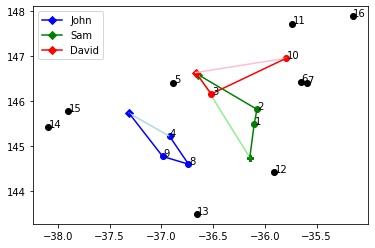

In [22]:
import matplotlib.pyplot as plt

list_colors = ['b','g','r','c','darkviolet','y']
list_light_colors = ['lightblue','lightgreen','pink','lightcyan','violet','lightyellow']
number_of_colors = len(list_colors)
done_tasks=list()
for r in range(number_of_ressources):
  color_r = list_colors[r % number_of_colors]
  light_color_r = list_light_colors[r % number_of_colors]
  plt.plot(ressources[L_ressources[r]].latitude,ressources[L_ressources[r]].longitude, color = color_r, marker="D", label=L_ressources[r])
  for a in range(number_of_tasks+number_of_runavailabilities): # placement du chemin entre maison et tâches classiques
    if a >= number_of_tasks:
      a_latitude = ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].latitude
      a_longitude = ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].longitude
      if x[(a,r)]==1 : # si la tâche obligatoire n°a est associée à la ressource r alors :
        plt.plot(a_latitude, a_longitude, color = color_r, marker="P")
    else:
      a_latitude = tasks[L_tasks[a]].latitude
      a_longitude = tasks[L_tasks[a]].longitude
      if round(x[(a,r)].x) == 1 :
        done_tasks.append(a)
        plt.plot(a_latitude, a_longitude, color = color_r, marker="o")
        plt.annotate(str(a+1), [a_latitude+0.005, a_longitude+0.005])
    if round(d[(r,a)].x) == 1:
      plt.plot([a_latitude, ressources[L_ressources[r]].latitude], [a_longitude, ressources[L_ressources[r]].longitude], color = light_color_r)
    if round(f[(r,a)].x) == 1:
      plt.plot([a_latitude, ressources[L_ressources[r]].latitude], [a_longitude, ressources[L_ressources[r]].longitude], color = color_r)
    for b in range(number_of_tasks+number_of_runavailabilities):
      if b >= number_of_tasks:
        b_latitude = ressources[L_ressources[runav_id[b-number_of_tasks][0]]].unavailabilities[runav_id[b-number_of_tasks][1]].latitude
        b_longitude = ressources[L_ressources[runav_id[b-number_of_tasks][0]]].unavailabilities[runav_id[b-number_of_tasks][1]].longitude
      else:
        b_latitude = tasks[L_tasks[b]].latitude
        b_longitude = tasks[L_tasks[b]].longitude
      if round(y[(r,a,b)].x) == 1:
        plt.plot([a_latitude, b_latitude], [a_longitude, b_longitude], color = color_r)
for t in range(number_of_tasks):
  if t not in done_tasks:
    plt.plot(tasks[L_tasks[t]].latitude, tasks[L_tasks[t]].longitude, color = 'black', marker="o")
    plt.annotate(str(t+1), [tasks[L_tasks[t]].latitude+0.005, tasks[L_tasks[t]].longitude+0.005])
plt.legend()
plt.savefig('parcours_{}_V2.png'.format(ville), dpi=500, transparent=False)
plt.show()

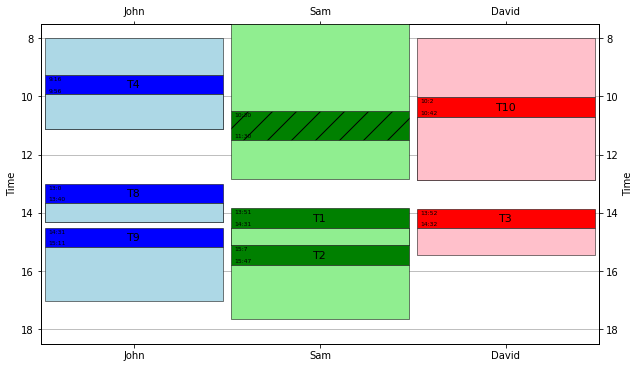

In [23]:
"""
startTimesT = [s[t].x for t in range(number_of_tasks)]
startTimesU = [ressources[L_ressources[runav_id[t][0]]].unavailabilities[runav_id[t][1]].unavailabilityStart for t in range(number_of_runavailabilities)]
endTimesT = [s[t].x+tasks[L_tasks[t]].duration for t in range(number_of_tasks)]
endTimesU = [ressources[L_ressources[runav_id[t][0]]].unavailabilities[runav_id[t][1]].unavailabilityEnd for t in range(number_of_runavailabilities)]
startTimes=startTimesT+startTimesU
endTimes=endTimesT+endTimesU
"""
operators=[L_ressources[r] for r in range(number_of_ressources)]
colors=list_colors[0:number_of_ressources]
light_colors=list_light_colors[0:number_of_ressources]

fig=plt.figure(figsize=(10,5.89))

# Set Axis
ax=fig.add_subplot(111)
ax.yaxis.grid()
ax.set_xlim(0.5,len(operators)+0.5)
ax.set_ylim(18.5, 7.5)
ax.set_xticks(range(1,len(operators)+1))
ax.set_xticklabels(operators)
ax.set_ylabel('Time')

# Set Second Axis
ax2=ax.twiny().twinx()
ax2.invert_yaxis()
ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(operators)
ax2.set_ylabel('Time')

for r in range(number_of_ressources):
    color_r = colors[r % number_of_colors]
    light_color_r = light_colors[r % number_of_colors]
    operator_room = r+1-0.48
    for a in range(number_of_tasks):
        if round(x[(a,r)].x) == 1 :
            event="T"+str(a+1)
            start = startTimesT[a]/60
            end = endTimesT[a]/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=color_r, edgecolor='k', linewidth=0.5)
            plt.text(operator_room+0.02, start+0.05 ,'{}:{}'.format(int(start), int(start*60)%60), va='top', fontsize=6)
            plt.text(operator_room+0.02, end-0.05,'{}:{}'.format(int(end), int(end*60)%60), va='bottom', fontsize=6)
            plt.text(operator_room+0.48, (start+end)*0.5, event, ha='center', va='center', fontsize=11)
        for b in range(number_of_tasks):
            if round(y[(r,a,b)].x) == 1:
                start = endTimesT[a]/60
                end = start+(distances[a][b]/vitesse)/60
                plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
        if round(d[(r,a)].x) == 1:
            start = (startTimesT[a]-distances_m[r][a]/vitesse)/60
            end = startTimesT[a]/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
        if round(f[(r,a)].x) == 1:
            start=endTimesT[a]/60
            end=start+(distances_m[r][a]/vitesse)/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
    for a in range(number_of_tasks, number_of_tasks+number_of_runavailabilities):
        if round(x[(a,r)]) == 1 :
            event=""
            start = startTimesU[a-number_of_tasks]/60
            end = endTimesU[a-number_of_tasks]/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=color_r, hatch = '/', edgecolor='k', linewidth=0.5)
            plt.text(operator_room+0.02, start+0.05 ,'{}:{}'.format(int(start), int(start*60)%60), va='top', fontsize=6)
            plt.text(operator_room+0.02, end-0.05,'{}:{}'.format(int(end), int(end*60)%60), va='bottom', fontsize=6)
            plt.text(operator_room+0.48, (start+end)*0.5, event, ha='center', va='center', fontsize=11)
        if round(d[(r,a)].x) == 1:
            start = (startTimesU[a-number_of_tasks]-distances_m[r][a]/vitesse)/60
            end = startTimesU[a-number_of_tasks]/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
        if round(f[(r,a)].x) == 1:
            start=endTimesU[a-number_of_tasks]/60
            end=start+(distances_m[r][a]/vitesse)/60
            plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)
    for a in range(number_of_tasks+number_of_runavailabilities):
        for b in range(number_of_tasks+number_of_runavailabilities):
            if round(y[(r,a,b)].x) == 1:
                if a<number_of_tasks: # si a est une tâche "réelle"
                    start = endTimesT[a]/60
                else : # si a est une "resource unavailability"
                    start = endTimesU[a-number_of_tasks]/60
                end = start+(distances[a][b]/vitesse)/60
                plt.fill_between([operator_room, operator_room+0.96], [start, start], [end,end], color=light_color_r, edgecolor='k', linewidth=0.5)

plt.savefig('timetable_{}_V2.png'.format(ville), dpi=500, transparent=False)
plt.show()

### Fonctions de test de faisabilité des résultats

In [24]:
# check que les techniciens ont le bon niveau et les bonnes compétences pour les tâches exécutées
a = True
for j in range(number_of_ressources):
    for i in range(number_of_tasks):
        if round(x[(i,j)].x):
            # check que le skill est bon
            if ressources[L_ressources[j]].skill!=tasks[L_tasks[i]].skill:
                print("fail r,t ",j,i)
                a = False
            # check que le level est bon
            if ressources[L_ressources[j]].level < tasks[L_tasks[i]].level:
                print("fail r,t ",j,i)
                a = False
if a :
    print("Les techniciens ont bien les bonnes compétences et le bon niveau pour toutes les tâches exécutées")
            

Les techniciens ont bien les bonnes compétences et le bon niveau pour toutes les tâches exécutées


In [25]:
# check que les contraintes d'ouverture et de fermeture des tâches sont respectées en début et fin de journée
a = True
for j in range(number_of_ressources):
    for i in range(number_of_tasks):
        if round(x[(i,j)].x):
            if s[i].x < tasks[L_tasks[i]].openingTime:
                print("fail r,t ",j,i)
                a = False
            if tasks[L_tasks[i]].closingTime < s[i].x + tasks[L_tasks[i]].duration :
                print("fail r,t ",j,i)
                a = False

            
            
if a :
    print("Les contraintes d'ouverture et de fermeture des tâches sont respectées")

Les contraintes d'ouverture et de fermeture des tâches sont respectées


In [26]:
# chaque employé possède une pause midi d’une durée d’1h à placer entre 12h et 14h, dans un lieu quelconque
bool = False
for i in range(number_of_ressources):
    bool = False
    if round(ze[i].x):
        print("l'employé ", L_ressources[i], " fait sa pause à la fin de sa journée ")
        bool = True
    elif round(zb[i].x):
        print("l'employé ", L_ressources[i], " fait sa pause au début de sa journée ")
        bool = True
    for a in range(number_of_tasks+number_of_runavailabilities):
        for b in range(number_of_tasks+number_of_runavailabilities):
            if round(u[i].x)==0:
                bool=True
            if round(z[(i,a,b)].x) and round(u[i].x):
                bool = True
                print("l'employé ", L_ressources[i], " fait sa pause entre les tâches ", a+1, "et ", b+1)
    if bool ==False:
        print("l'employé ", L_ressources[i], "n'a pas de pause !!")

l'employé  John  fait sa pause entre les tâches  4 et  8
l'employé  Sam  fait sa pause entre les tâches  17 et  1
l'employé  David  fait sa pause entre les tâches  10 et  3


In [27]:
# certains employés peuvent avoir des périodes d’indisponibilité dans la journée
 
bool = True
for r in range(number_of_ressources):
    for R,id in runav_id:
        if r == R:
            for t in range(number_of_tasks):
                if round(x[(t,r)].x):
                    if s[t].x<= ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].unavailabilityStart:
                        if s[t].x+ tasks[L_tasks[j]].duration > ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].unavailabilityStart:
                            print("la personne ",  L_ressources[r], "fait la tâche ", t+1, "alors qu'elle a une indisponibilité ", id+1)
                            bool = False
                    elif s[t].x< ressources[L_ressources[runav_id[a-number_of_tasks][0]]].unavailabilities[runav_id[a-number_of_tasks][1]].unavailabilityEnd:
                        print("la personne ",  L_ressources[r], "fait la tâche ", t+1, "alors qu'elle a une indisponibilité ", id+1)
                        bool = False

if bool :
    print("les indispos de ressource sont respectées")


les indispos de ressource sont respectées


In [28]:
# certaines tâches ne peuvent pas être faites à certains créneaux
 
b = True
for t in range(number_of_tasks):
    for T,id in tunav_id:
        if t == T:
            for r in range(number_of_ressources):
                if round(x[(t,r)].x):
                    if s[t].x<= tasks[L_tasks[T]].unavailabilities[id].unavailabilityStart:
                        if s[t].x+ tasks[L_tasks[T]].duration > tasks[L_tasks[T]].unavailabilities[id].unavailabilityStart:
                            print("la personne ", r+1, "fait la tâche ", t+1, " alors que cette tâche n'est pas dispo ", id+1)
                            b = False
                    elif s[t].x < tasks[L_tasks[T]].unavailabilities[id].unavailabilityEnd:
                        print("la tâche ", t+1, " est faite sur un créneau d'indisponibilité ", id+1)
                        b = False
if b :
    print("les indispos de tâches sont respectées")


les indispos de tâches sont respectées
